## Multilabel Classification using CNN

In [203]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb

#### `1. Data Loading and Preprocessing`

In [204]:
def one_hot_encode(label_str):
    """
    One-hot encode each label into a 33-length vector with 11 classes for each digit position.
    10 (0-9) classes for each digit position and 1 class for "null" (no digit).
    """

    def encode_position(value):
        encoding = np.zeros(11)
        if value == 'null':
            encoding[10] = 1
        else:
            encoding[int(value)] = 1
        return encoding
    
    if len(label_str) == 1:
        if label_str == '0':
            hundreds, tens, units = 'null', 'null', 'null'
        else:
            hundreds, tens, units = 'null', 'null', label_str
    elif len(label_str) == 2:
        hundreds, tens, units = 'null', label_str[0], label_str[1]
    else:
        hundreds, tens, units = label_str[0], label_str[1], label_str[2]

    hundreds_encoded = encode_position(hundreds)
    tens_encoded = encode_position(tens)
    units_encoded = encode_position(units)

    one_hot_label = np.concatenate([hundreds_encoded, tens_encoded, units_encoded])

    return one_hot_label


In [205]:
path_to_mnist = "../../data/external/double_mnist"

def load_mnist_data(path_to_data):
    """
    Load the MNIST data into train, validation and test sets.
    Takes in the path to the data and returns the data in the following format:
    (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)
    where train_data, val_data and test_data are numpy arrays of images 
    and train_labels, val_labels and test_labels are numpy arrays of labels.
    """
    def load_images_from_folder(folder_path, label_function):
        data = []
        labels = []
        for subfolder in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder)
            if os.path.isdir(subfolder_path):
                label = label_function(subfolder)
                for img_name in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img_name)
                    if img_path.endswith('.png') or img_path.endswith('.jpg'):
                        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                        if img is not None:
                            data.append(img)
                            labels.append(label)

        return np.array(data), np.array(labels)
    
    def one_hot_encoded_digits(folder_name):
        folder_name_string = str(folder_name)
        return one_hot_encode(folder_name_string)
    
    train_path = os.path.join(path_to_data, 'train')
    val_path = os.path.join(path_to_data, 'val')
    test_path = os.path.join(path_to_data, 'test')
    
    train_data, train_labels = load_images_from_folder(train_path, one_hot_encoded_digits)
    val_data, val_labels = load_images_from_folder(val_path, one_hot_encoded_digits)
    test_data, test_labels = load_images_from_folder(test_path, one_hot_encoded_digits)
    
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

path_to_mnist = "../../data/external/double_mnist"
train_set, val_set, test_set = load_mnist_data(path_to_data=path_to_mnist)
print(f"Loaded {len(train_set[0])} train images, {len(val_set[0])} validation images, {len(test_set[0])} test images.")


Loaded 12600 train images, 3000 validation images, 4600 test images.


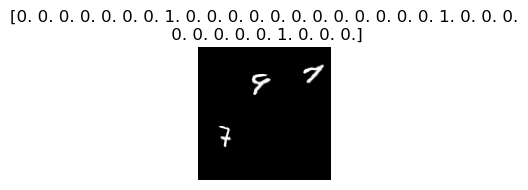

In [206]:
# checking if the data is loaded correctly by displaying some images

def display_images(images, labels, n_images):
    plt.figure(figsize=(10, 10))
    for i in range(n_images):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'{labels[i]}')
        plt.axis("off")
    plt.show()

display_images(train_set[0], train_set[1], 1)
# display_images(val_set[0], val_set[1], 1)
# display_images(test_set[0], test_set[1], 1)


In [207]:
"""
MultiMNISTDataset class - inherited from torch.utils.data.Dataset 
and __len__ and __getitem__ functions are overridden.
"""

class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [208]:
# np array -> pil image -> resize -> tensor

def load_data():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor()
    ])

    train_dataset = MultiMNISTDataset(train_set[0], train_set[1], transform=transform)
    val_dataset = MultiMNISTDataset(val_set[0], val_set[1], transform=transform)
    test_dataset = MultiMNISTDataset(test_set[0], test_set[1], transform=transform)

    # labels are tensors -> long
    train_dataset.labels = torch.tensor(train_dataset.labels).float()
    val_dataset.labels = torch.tensor(val_dataset.labels).float()
    test_dataset.labels = torch.tensor(test_dataset.labels).float()

    batch_size = 32

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

#### `2. Implement the Multilabel CNN Class`

In [230]:
class MultilabelCNN(nn.Module):
    """
    CNN class - inherited from torch.nn.Module
    Hnadles multilabel classification tasks.
    Contains convolutional layers and fully connected layers.
    Also contains forward function to define the forward pass.
    """

    # commented out parts are for architecture 2

    def __init__(self, dropout_prob=0.3):
        super(MultilabelCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # self.fc1 = nn.Linear(in_features=128*8*8, out_features=128)
        self.fc1 = nn.Linear(in_features=256*4*4, out_features=128)
        self.fc1_drop = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(in_features=128, out_features=33)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        # x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

        

Yes, this model does require an activation function after the last linear layer because it handles a multi-label classification problem. In multi-label classification, each class is treated independently, meaning the model should output probabilities for each class separately rather than as mutually exclusive options (as in single-label classification).

Here, a sigmoid activation is suitable after the final layer because it gets each output to a range between 0 and 1, effectively representing the probability of each class being present.

In [231]:
def train(model, train_loader, val_loader, optimizer, num_epochs, 
          device, wandb_flag=False, epoch_logging=True):
    
    criterion = nn.BCELoss()

    old_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        val_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # intialize the gradients to zero
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)

            # calculate the loss
            loss = criterion(outputs, labels)

            # backward pass
            loss.backward()

            # update the weights
            optimizer.step()

            train_loss += loss.item()            

        # validation loss
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward pass
                outputs = model(inputs)

                # val loss
                loss = criterion(outputs, labels)

                old_val_loss = val_loss
                val_loss += loss.item()

        if epoch_logging:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

        if wandb_flag:
            wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})

        if np.abs(val_loss - old_val_loss) < 1e-5:
            if epoch_logging:
                print("No improvement in validation loss. Stopping training.")
            break
        

In [232]:
def train_driver(
        num_epochs=10, 
        optimizer_type='adam', 
        device=None, 
        lr=0.001, 
        dropout_prob=0.5, 
        wandb_flag=False, 
        epoch_logging=True):
    
    model = MultilabelCNN(dropout_prob=dropout_prob)
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    train_loader, val_loader, test_loader = load_data()
    train(model, train_loader, val_loader, optimizer, num_epochs=num_epochs, 
            device=device, wandb_flag=wandb_flag, epoch_logging=epoch_logging)
    return model, val_loader, test_loader, train_loader
    

In [233]:
def test_model(model, test_loader, device, logging=True):
    model.eval()
    num_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # take argmax of the output from 0:10, 11:21, 22:32 

            first_digit_max = torch.argmax(outputs[:, :11], dim=1)
            second_digit_max = torch.argmax(outputs[:, 11:22], dim=1)
            third_digit_max = torch.argmax(outputs[:, 22:], dim=1)

            all_preds.append(np.stack([first_digit_max, second_digit_max, third_digit_max], axis=1))

            # check the indices where labels are not 0
            first_digit = torch.argmax(labels[:, :11], dim=1)
            second_digit = torch.argmax(labels[:, 11:22], dim=1)
            third_digit = torch.argmax(labels[:, 22:], dim=1)

            all_labels.append(np.stack([first_digit, second_digit, third_digit], axis=1))

            num_samples += labels.size(0)

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    exact_match_accuracy = np.all(all_preds == all_labels, axis=1).mean()
    hamming_score = 1 - np.mean(all_preds != all_labels)

    if logging:
        print(f"Exact Match Accuracy: {exact_match_accuracy:.4f}")
        print(f"Hamming Score: {hamming_score:.4f}")

    return exact_match_accuracy, hamming_score


Explanation of the performance metrics:

The predictions(probablities) are divided into 3 groups (each for a digit) and then the max probability is taken for each group (as we know that only one digit is present in each group). The index of this max probability of each group (array of length 3 - for 3 digits) is considered to calculate the exact matching accuracy and hamming score.

1. Exact Matching Accuracy: This calculates the ratio of exact matches between the true and predicted labels to the total number of samples.

2. Hamming Score: Hamming loss calculates the fraction of labels that are incorrectly predicted. The hamming score is the complement of the hamming loss.


In [213]:
# display some predictions - visualizing the model's output

def decode_label(label):
    """
    Decode the one-hot encoded label into the original label.
    """
    def decode_position(position):
        if position == 10:
            return 'null'
        else:
            return str(position)
    
    hundreds = np.argmax(label[:11])
    tens = np.argmax(label[11:22])
    units = np.argmax(label[22:33])

    hundreds = decode_position(hundreds)
    tens = decode_position(tens)
    units = decode_position(units)

    if hundreds == 'null':
        if tens == 'null':
            return units
        else:
            return tens + units
    else:
        return hundreds + tens + units

def display_predictions(model, test_loader, device, n_images=5):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            predictions = torch.zeros_like(outputs, dtype=torch.int)

            first_digit_max = torch.argmax(outputs[:, :11], dim=1)
            second_digit_max = torch.argmax(outputs[:, 11:22], dim=1)
            third_digit_max = torch.argmax(outputs[:, 22:], dim=1)

            predictions[torch.arange(outputs.size(0)), first_digit_max] = 1
            predictions[torch.arange(outputs.size(0)), second_digit_max + 11] = 1
            predictions[torch.arange(outputs.size(0)), third_digit_max + 22] = 1

            plt.figure(figsize=(15, 5))
            for i in range(n_images):
                img = inputs[i].squeeze().cpu().numpy()
                ax = plt.subplot(1, n_images, i + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f'Pred: {decode_label(predictions[i].cpu().numpy())}\nLabel: {decode_label(labels[i].cpu().numpy())}')
                plt.axis("off")
            plt.show()
            break

In [215]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_classification, val_loader, test_loader, train_loader = train_driver(num_epochs=5, optimizer_type='adam',
                                                              lr=0.001, device=device, dropout_prob=0.3)

Epoch 1/5, Train Loss: 0.20875076940141354, Val Loss: 0.19027015091256894
Epoch 2/5, Train Loss: 0.1317338524622663, Val Loss: 0.13172836688921807
Epoch 3/5, Train Loss: 0.0944304562310882, Val Loss: 0.11533187686445866
Epoch 4/5, Train Loss: 0.07264202201578218, Val Loss: 0.09038858821100378
Epoch 5/5, Train Loss: 0.0590243819051512, Val Loss: 0.11074004758228646


In [225]:
print("\nClassification model training complete.")

print("\nEvaluating the model on the validation set.")
_,_ = test_model(model_classification, val_loader, device)

print("\nEvaluating the model on the test set.")
_,_ = test_model(model_classification, test_loader, device)

print("\nEvaluating the model on the train set.")
_,_ = test_model(model_classification, train_loader, device)



Classification model training complete.

Evaluating the model on the validation set.
Exact Match Accuracy: 0.6503
Hamming Score: 0.8767

Evaluating the model on the test set.
Exact Match Accuracy: 0.4759
Hamming Score: 0.8191

Evaluating the model on the train set.
Exact Match Accuracy: 0.8870
Hamming Score: 0.9598


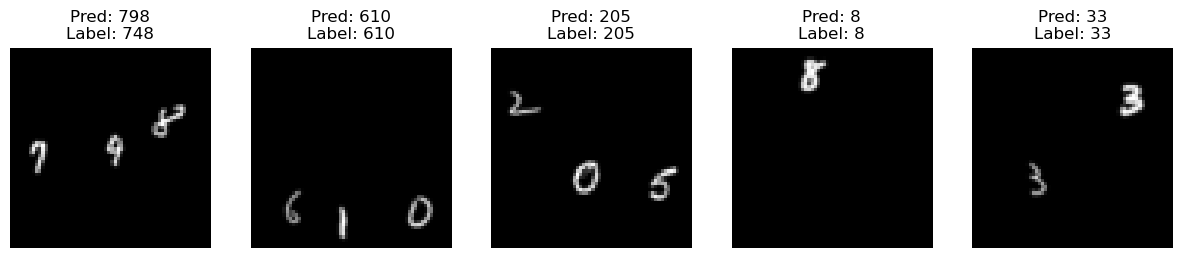

In [220]:
display_predictions(model_classification, train_loader, device, n_images=5)

#### `3. Hyperparameter Tuning`

Hyperparameter tuning for the Multilabel CNN model
1. learning rate
2. optimizer
3. dropout rate
4. convolutional layers

There are 2 architectures that are tried:
1. 4 Convolutional layers each with batch normalization and ReLU activation followed by 2 linear layers with dropout in between.
2. 3 Convolutional layers each without batch normalization and ReLU activation followed by 2 linear layers with dropout in between.

The plots are plotted for each run (refer to wandb link below)

In [235]:
def sweep_train():
    with wandb.init() as run:
        config = run.config
        wandb.run.name = f"{config.optimizer_type}_{config.lr}_{config.dropout_prob}"
        model, val_loader, test_loader, train_loader = train_driver(
            num_epochs=5, 
            optimizer_type=config.optimizer_type,
            lr=config.lr, 
            device=device, 
            dropout_prob=config.dropout_prob, 
            wandb_flag=True,
            epoch_logging=False
        )
        
        val_acc, val_hamming = test_model(model, val_loader, device, logging=False)
        test_acc, test_hamming = test_model(model, test_loader, device, logging=False)
        train_acc, train_hamming = test_model(model, train_loader, device, logging=False)

        wandb.log({"val_exact_match_accuracy": val_acc, "val_hamming_score": val_hamming,
                     "test_exact_match_accuracy": test_acc, "test_hamming_score": test_hamming,
                     "train_exact_match_accuracy": train_acc, "train_hamming_score": train_hamming})


def hyperparameter_tuning():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            
            'optimizer_type': {
                'values': ['adam', 'sgd']
            },
            'lr': {
                'values': [0.001, 0.01]
            },
            'dropout_prob': {
                'values': [0.3, 0.4]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='SMAI_ASG_4_MultilabelCNN')
    wandb.agent(sweep_id, function=sweep_train)

In [ ]:
hyperparameter_tuning()

[WandB Link](https://wandb.ai/abhinav7/SMAI_ASG_4_MultilabelCNN)

**Best Model**:  
  - Learning Rate: 0.001  
  - Optimizer: Adam  
  - Dropout Rate: 0.3  
  
  - Validation Exact Match Accuracy: 0.620   
  - Test Exact Match Accuracy: 0.464   
  - Train Exact Match Accuracy: 0.827   
  - Validation Hamming Score: 0.851     
  - Test Hamming Score: 0.790  
  - Train Hamming Score: 0.938  
  - Validation Loss: 0.16    
  - Train Loss: 0.066   

